In [57]:
import torch
import torch.optim as optim

In [58]:
# recorded temperature data, c - celsius, u - unknown
t_cel = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_cel = torch.tensor(t_cel)
t_u = torch.tensor(t_u)
t_un = t_u * 0.1

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_t_u = t_u[train_indices]
train_t_cel = t_cel[train_indices]
val_t_u = t_u[val_indices]
val_t_cel = t_cel[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [59]:
def model(t_un, w2, w1, b):
    return w2 * t_un**2 + w1 * t_un + b
def loss_fn(t_cel, t_p):
    squared_loss = (t_cel - t_p) ** 2
    return squared_loss.mean()

In [60]:
def training_loop(n_epochs, train_t_un, train_t_cel, val_t_un, val_t_cel, params, optimizer):

    for epoch in range(1, n_epochs+1):
        train_t_p = model(train_t_un, *params)
        train_loss = loss_fn(train_t_cel, train_t_p)

        with torch.no_grad():
            val_t_p = model(val_t_un, *params)
            val_loss = loss_fn(val_t_cel, val_t_p)
            assert val_loss.requires_grad == False
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch % 1000 == 0 or epoch <= 3:
            print(f'Epoch {epoch}, Training loss {train_loss.item():.4f}, Validation loss {val_loss.item():.4f}')
    return params

params = torch.tensor([1., 1., 0.], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr = learning_rate)
training_loop(
    n_epochs=10000,
    train_t_un=train_t_un,
    train_t_cel=train_t_cel,
    val_t_un=val_t_un,
    val_t_cel=val_t_cel,
    params = params,
    optimizer=optimizer
)

Epoch 1, Training loss 762.2029, Validation loss 286.9559
Epoch 2, Training loss 412.8053, Validation loss 171.4089
Epoch 3, Training loss 226.7675, Validation loss 105.8755
Epoch 1000, Training loss 9.8727, Validation loss 3.1247
Epoch 2000, Training loss 7.1640, Validation loss 0.9613
Epoch 3000, Training loss 5.7132, Validation loss 0.1954
Epoch 4000, Training loss 4.9334, Validation loss 0.0710
Epoch 5000, Training loss 4.5116, Validation loss 0.2125
Epoch 6000, Training loss 4.2808, Validation loss 0.4403
Epoch 7000, Training loss 4.1519, Validation loss 0.6736
Epoch 8000, Training loss 4.0774, Validation loss 0.8799
Epoch 9000, Training loss 4.0319, Validation loss 1.0503
Epoch 10000, Training loss 4.0020, Validation loss 1.1856


tensor([ 0.6280, -1.2942, -1.2593], requires_grad=True)

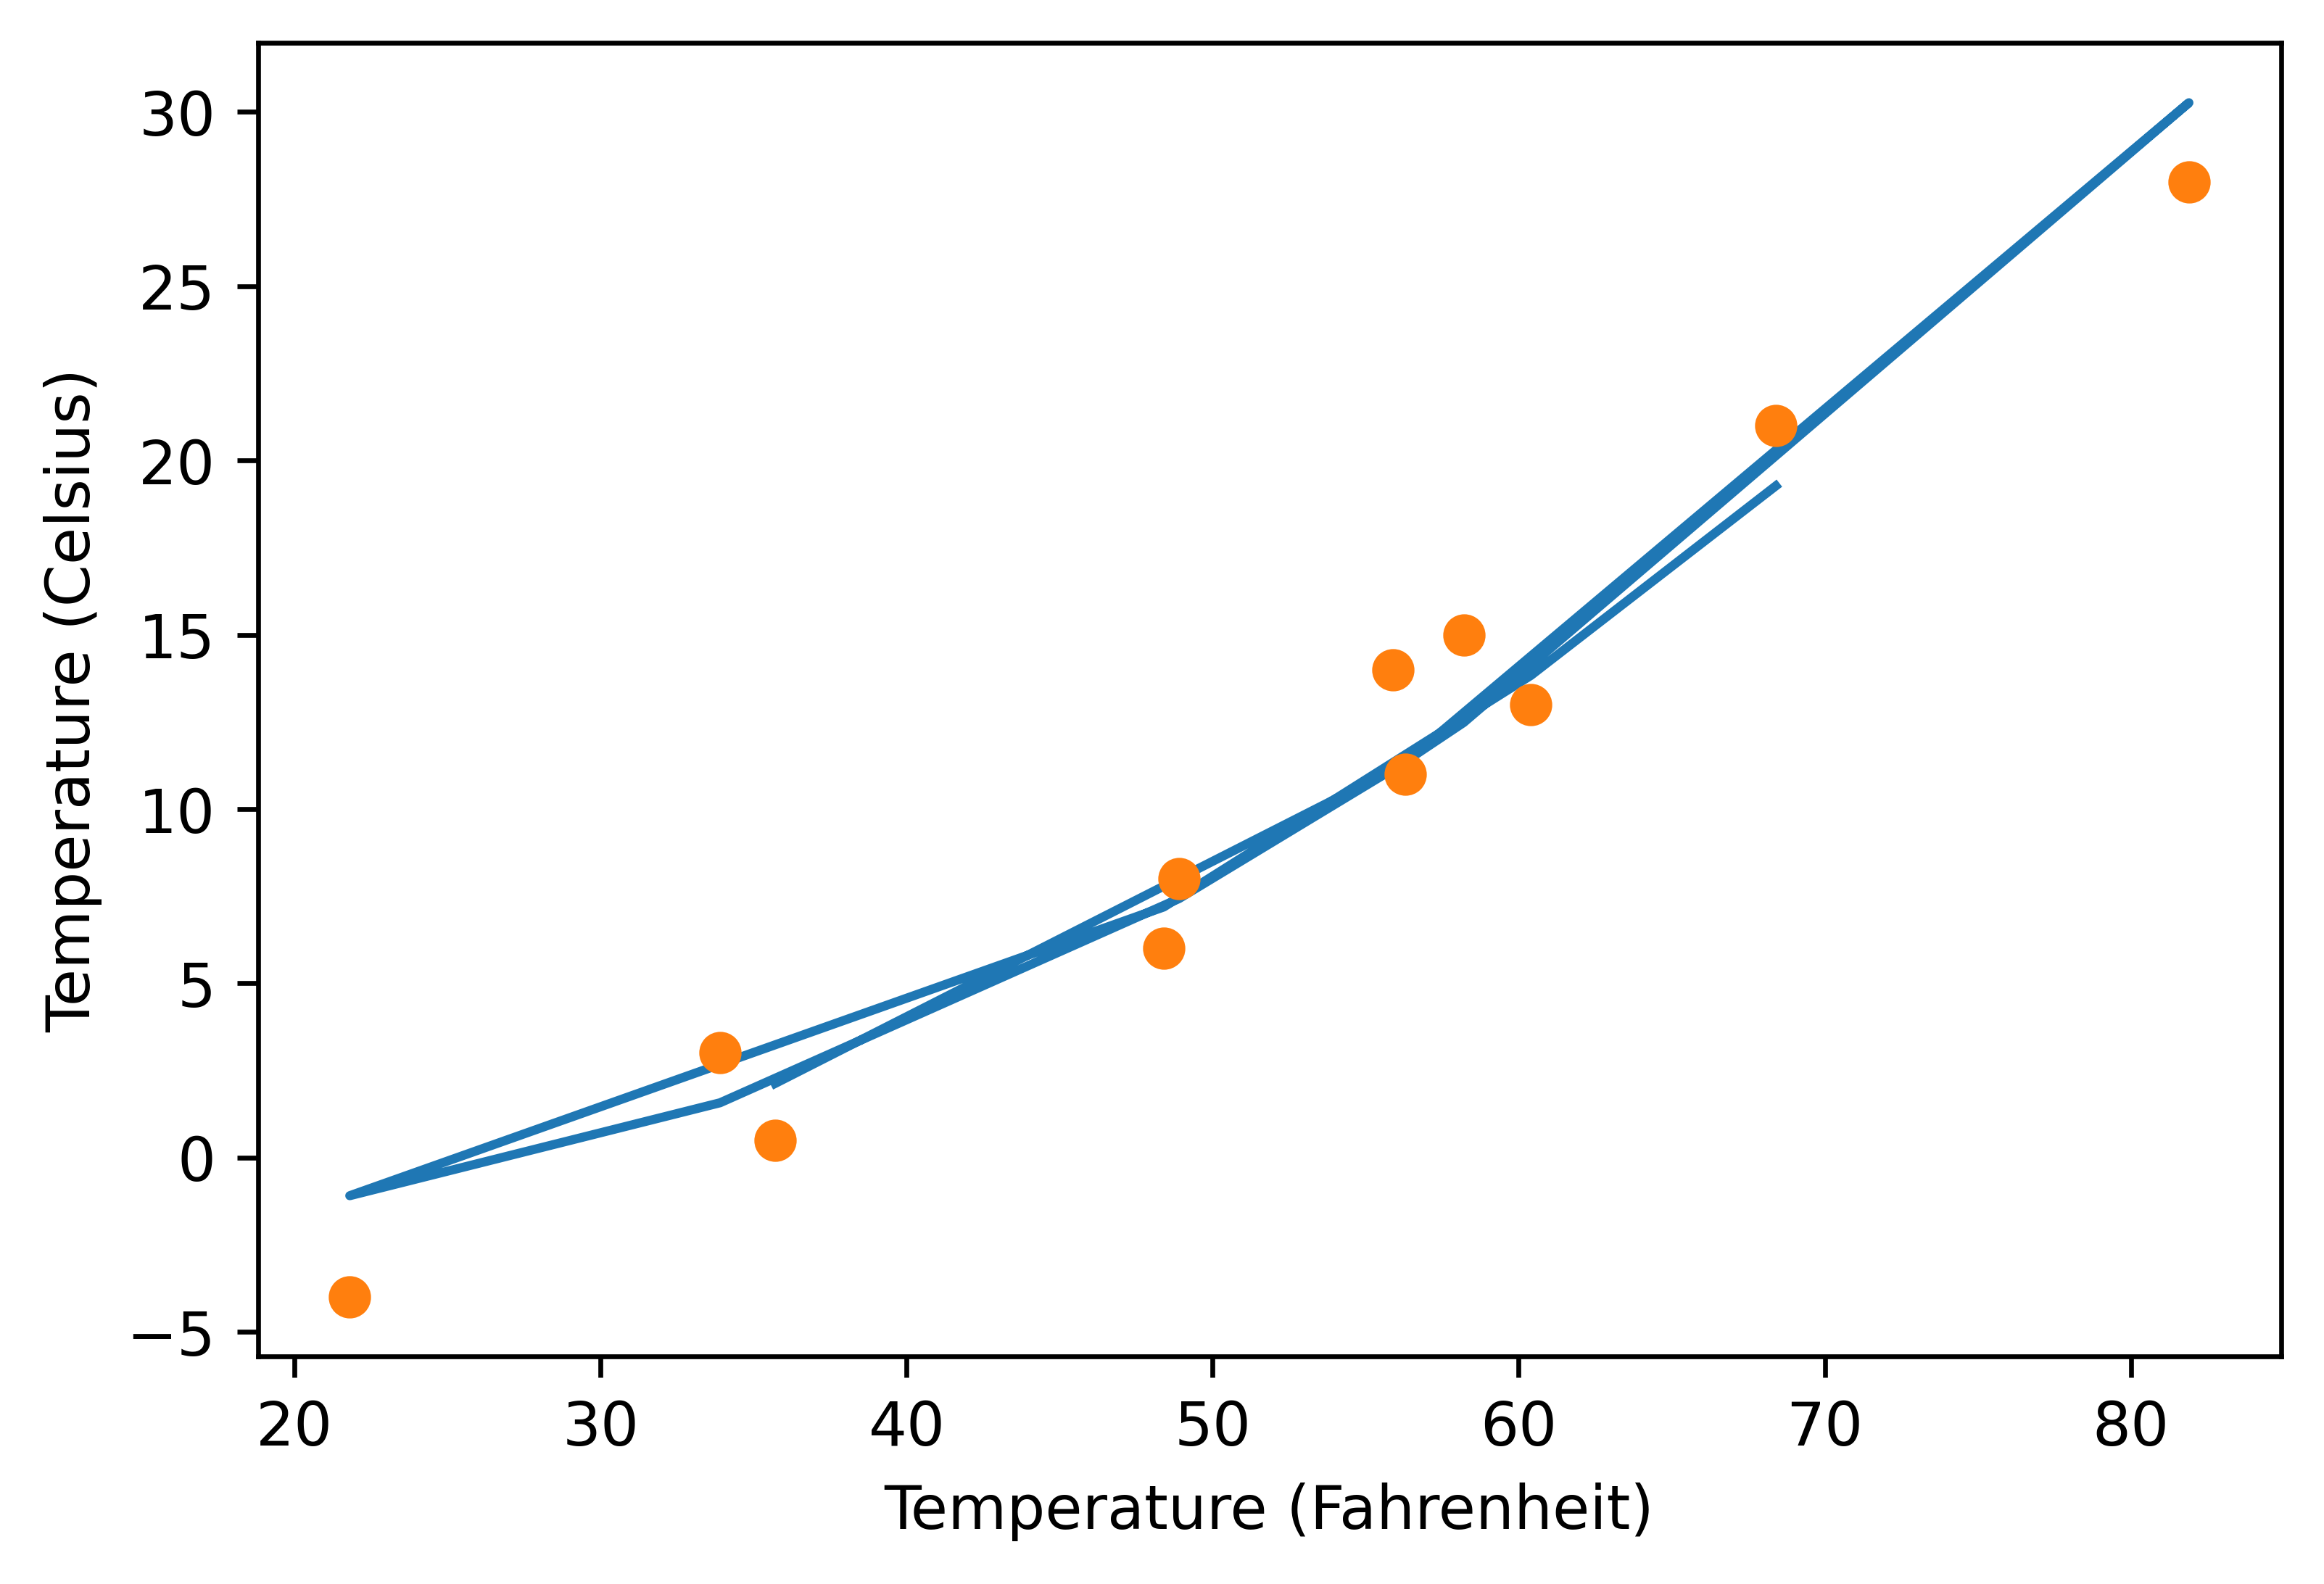

In [61]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)      # 技巧: 变量解包 *var 能分离出其内部的变量

fig = plt.figure(dpi=600)
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Temperature (Celsius)')
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_cel.numpy(), 'o')